# Anlise das informações e limpeza da base de dados Viagens_2025

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import ScalarFormatter
linhas_descartadas = []

In [141]:
def capturar_linha_ruim(linha):
    linhas_descartadas.append(linha)
    return None

In [142]:
df = pd.read_csv(
    "2025_Viagem.csv",
    sep=";",
    encoding="latin1",
    na_values=["Sem informação", -11, -1],
    engine="python",
    on_bad_lines=capturar_linha_ruim
)

mask = df['Justificativa Urgência Viagem'].isna()

df.loc[mask, 'Justificativa Urgência Viagem'] = 'Sem informação'

total_linhas_lidas = len(df)

linhas_valores_invalidos = df[df.isna().any(axis=1)]
total_linhas_valores_invalidos = len(linhas_valores_invalidos)

In [144]:
colunas_financeiras = ['Valor diárias', 'Valor passagens', 'Valor devolução', 'Valor outros gastos']

In [145]:
for col in colunas_financeiras:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace('R$', '', regex=False)
        df[col] = df[col].str.replace('.', '', regex=False)
        df[col] = df[col].str.replace(',', '.', regex=False)
        df[col] = df[col].str.strip()

In [146]:
df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

In [147]:
df[colunas_financeiras] = df[colunas_financeiras].astype(float)

In [148]:
df['Total gasto'] = (df['Valor diárias'] + 
                    df['Valor passagens'] + 
                    df['Valor outros gastos'] - 
                    df['Valor devolução'])


In [149]:
df = df.dropna(axis=1, how="all")
df = df.dropna(axis=0, how="any")

In [150]:
total_linhas_descartadas = len(linhas_descartadas)
total_linhas_validas = len(df)

print("RELATÓRIO DE LIMPEZA DO CSV")
print(f"Total de linhas lidas do arquivo: {total_linhas_lidas}")
print(f"Linhas descartadas por erro estrutural: {len(linhas_descartadas)}")
print(f"Linhas descartadas por conter valores inválidos para a pesquisa: {total_linhas_valores_invalidos}")
print(f"Linhas válidas finais: {len(df)}")

RELATÓRIO DE LIMPEZA DO CSV
Total de linhas lidas do arquivo: 751057
Linhas descartadas por erro estrutural: 0
Linhas descartadas por conter valores inválidos para a pesquisa: 620526
Linhas válidas finais: 130531


In [151]:
df['Período - Data de início'] = pd.to_datetime(df['Período - Data de início'], dayfirst=True)
df['Período - Data de fim'] = pd.to_datetime(df['Período - Data de fim'], dayfirst=True)
df['Mês - Ida'] = df['Período - Data de início'].dt.month_name()
df['Mês - Volta'] = df['Período - Data de fim'].dt.month_name()

In [152]:
meses_ordem = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']


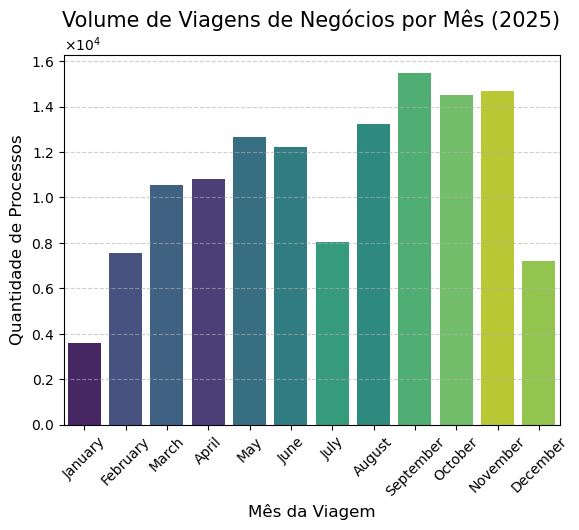

In [153]:
ax = sns.countplot(
    data=df, 
    x='Mês - Ida', 
    order=meses_ordem, 
    hue='Mês - Ida', 
    palette='viridis', 
    legend=False
)

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

ax.yaxis.set_major_formatter(formatter)

plt.title('Volume de Viagens de Negócios por Mês (2025)', fontsize=15, pad=20)
plt.xlabel('Mês da Viagem', fontsize=12)
plt.ylabel('Quantidade de Processos', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

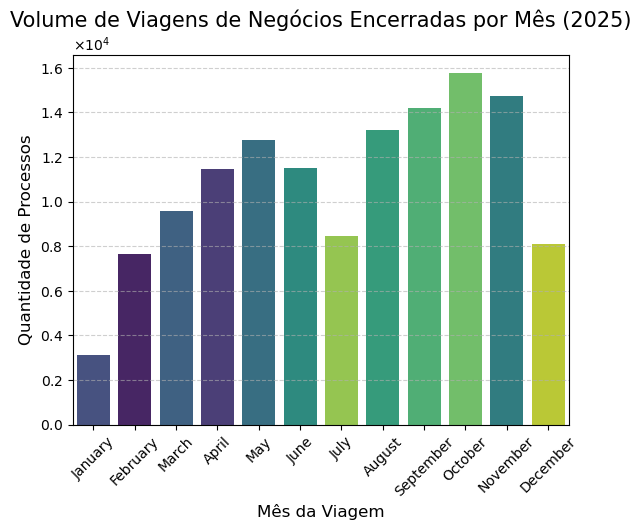

In [154]:
ax = sns.countplot(
    data=df, 
    x='Mês - Volta', 
    order=meses_ordem, 
    hue='Mês - Volta', 
    palette='viridis', 
    legend=False
)

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

ax.yaxis.set_major_formatter(formatter)

plt.title('Volume de Viagens de Negócios Encerradas por Mês (2025)', fontsize=15, pad=20)
plt.xlabel('Mês da Viagem', fontsize=12)
plt.ylabel('Quantidade de Processos', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

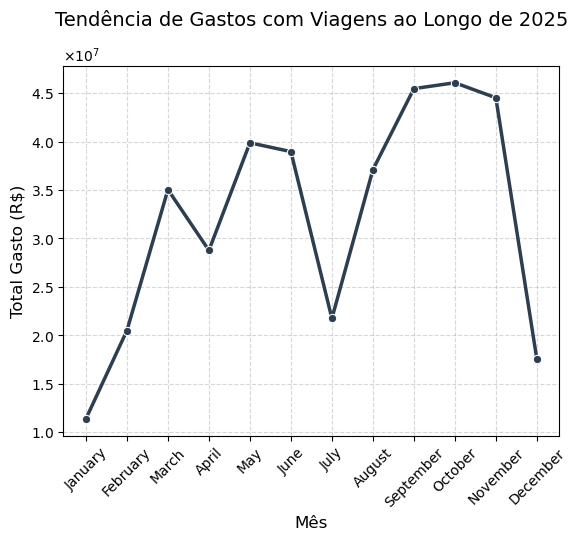

In [155]:
gastos_mensais = (
    df.groupby('Mês - Ida')['Total gasto']
      .sum()
      .reset_index()
)

gastos_mensais['Mês - Ida'] = pd.Categorical(
    gastos_mensais['Mês - Ida'],
    categories=meses_ordem,
    ordered=True
)

gastos_mensais = gastos_mensais.sort_values('Mês - Ida')

ax = sns.lineplot(
             data=gastos_mensais, 
             x='Mês - Ida',
             y='Total gasto',
             marker='o', 
             linewidth=2.5, 
             color='#2c3e50'
            )

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

ax.yaxis.set_major_formatter(formatter)

plt.title('Tendência de Gastos com Viagens ao Longo de 2025', fontsize=14, pad=15)
plt.ylabel('Total Gasto (R$)', fontsize=12)
plt.xlabel('Mês', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.xticks(rotation=45)

plt.show()

In [156]:
ranking_gastos = (df.groupby('Nome órgão solicitante')['Total gasto']
                  .sum()
                  .sort_values(ascending=False)
                  .head(10)
                  .reset_index())


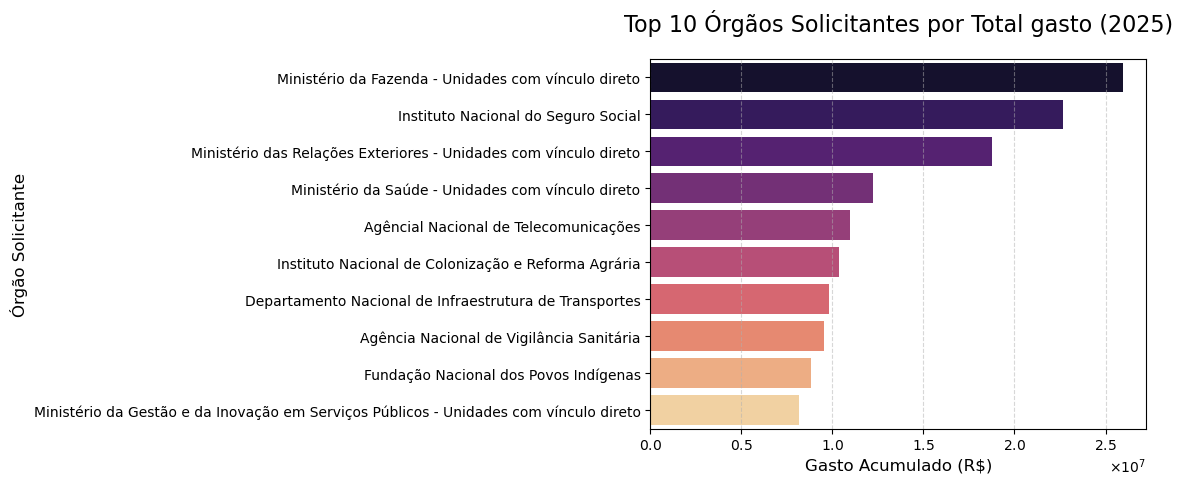

In [157]:
ax = sns.barplot(
    data=ranking_gastos, 
    x='Total gasto', 
    y='Nome órgão solicitante', 
    hue='Nome órgão solicitante', 
    palette='magma', 
    legend=False
)

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

ax.xaxis.set_major_formatter(formatter)

plt.title('Top 10 Órgãos Solicitantes por Total gasto (2025)', fontsize=16, pad=20)
plt.xlabel('Gasto Acumulado (R$)', fontsize=12)
plt.ylabel('Órgão Solicitante', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

In [158]:
top_destinos = df['Destinos'].value_counts().head(15).reset_index()
top_destinos.columns = ['Cidade/UF', 'Qtd_Viagens']

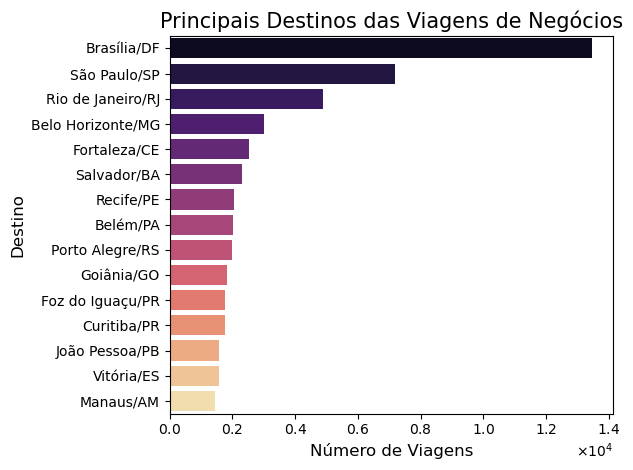

In [159]:
ax = sns.barplot(data=top_destinos, 
            x='Qtd_Viagens', 
            y='Cidade/UF', 
            hue='Cidade/UF', 
            palette='magma', 
            legend=False
           )

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

ax.xaxis.set_major_formatter(formatter)

plt.title('Principais Destinos das Viagens de Negócios', fontsize=15)
plt.xlabel('Número de Viagens', fontsize=12)
plt.ylabel('Destino', fontsize=12)
plt.tight_layout()
plt.show()

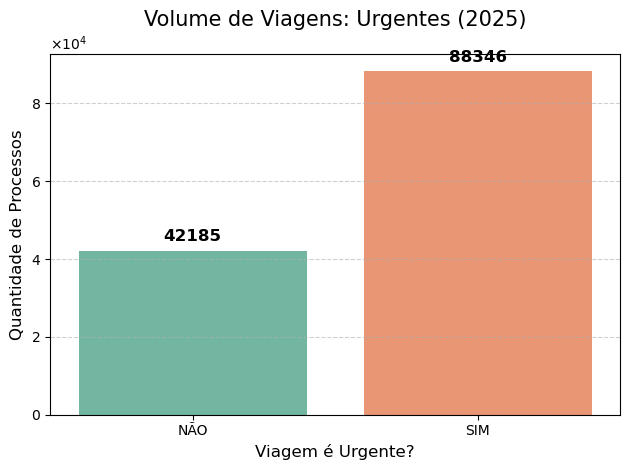

In [160]:
ax = sns.countplot(
    data=df, 
    x='Viagem Urgente', 
    hue='Viagem Urgente',
    palette='Set2', 
    legend=False
)
for p in plt.gca().patches:
    plt.gca().annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', 
        va='center', 
        xytext=(0, 10), 
        textcoords='offset points', 
        fontweight='bold',
        fontsize=12
    )

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

ax.yaxis.set_major_formatter(formatter)

plt.title('Volume de Viagens: Urgentes (2025)', fontsize=15, pad=20)
plt.xlabel('Viagem é Urgente?', fontsize=12)
plt.ylabel('Quantidade de Processos', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [161]:
top_funcoes = df['Descrição Função'].value_counts().head(10).reset_index()
top_funcoes.columns = ['Função', 'Quantidade']

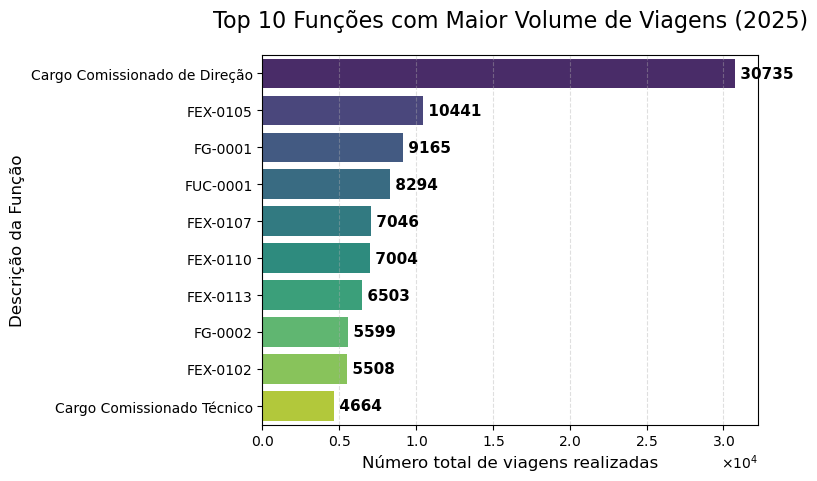

In [162]:
ax = sns.barplot(
    data=top_funcoes, 
    x='Quantidade', 
    y='Função', 
    hue='Função',
    palette='viridis', 
    legend=False
)
for index, value in enumerate(top_funcoes['Quantidade']):
    plt.text(value, index, f' {int(value)}', va='center', fontsize=11, fontweight='bold')

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

ax.xaxis.set_major_formatter(formatter)

plt.title('Top 10 Funções com Maior Volume de Viagens (2025)', fontsize=16, pad=20)
plt.xlabel('Número total de viagens realizadas', fontsize=12)
plt.ylabel('Descrição da Função', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.show()

In [163]:
top_orgaos = df['Nome órgão solicitante'].value_counts().nlargest(10).index
top_cargos = df['Descrição Função'].value_counts().nlargest(10).index

In [164]:
df_cruzado = df[df['Nome órgão solicitante'].isin(top_orgaos) & 
                df['Descrição Função'].isin(top_cargos)]

In [165]:
matriz_viagens = df_cruzado.groupby(['Nome órgão solicitante', 'Descrição Função']).size().unstack(fill_value=0)


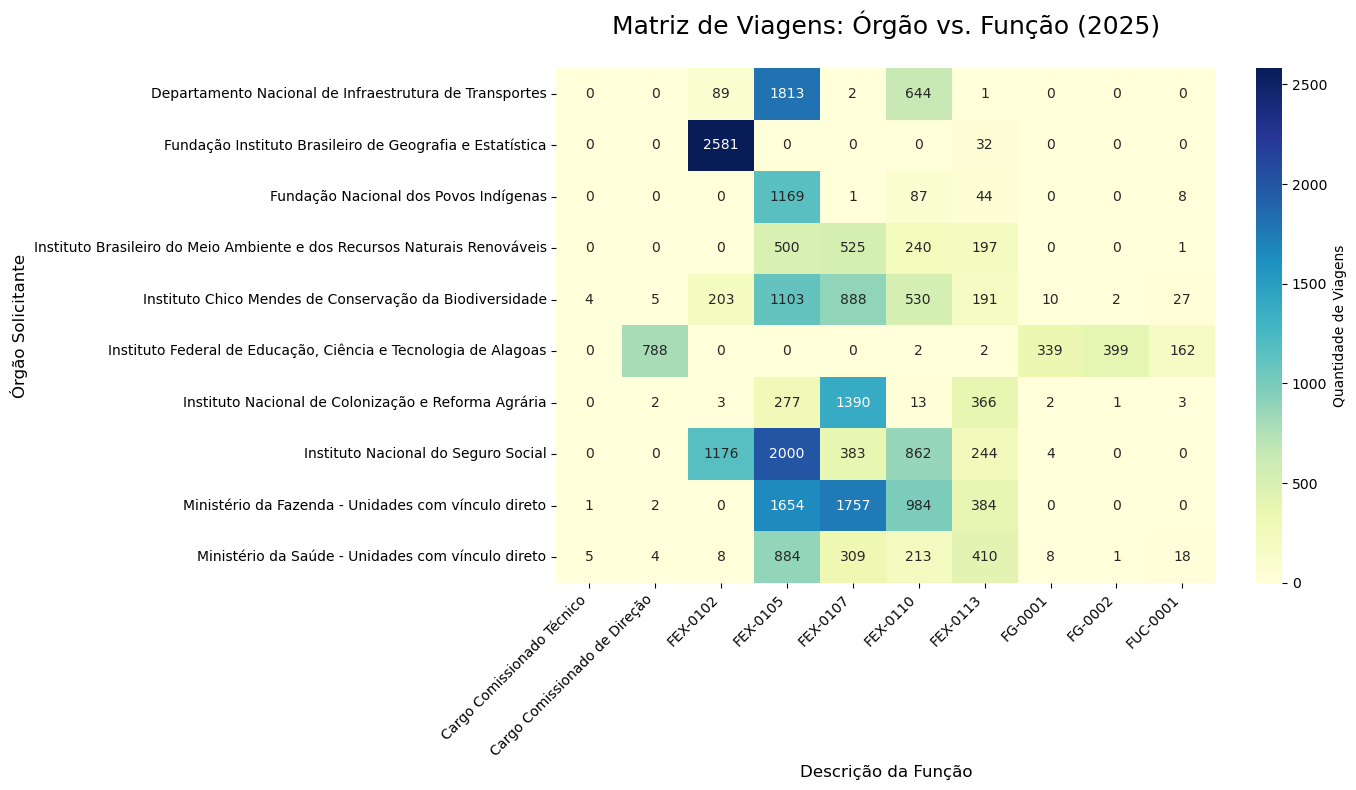

In [166]:
plt.figure(figsize=(14, 8))
sns.heatmap(
    matriz_viagens,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    cbar_kws={'label': 'Quantidade de Viagens'}
)
plt.title('Matriz de Viagens: Órgão vs. Função (2025)', fontsize=18, pad=25)
plt.xlabel('Descrição da Função', fontsize=12)
plt.ylabel('Órgão Solicitante', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

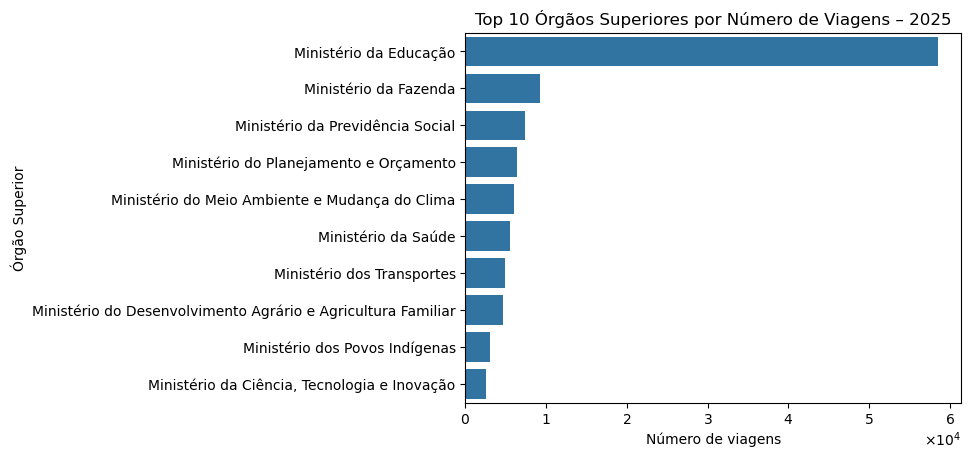

In [167]:
orgao_superior = df['Nome órgão solicitante']

viagens_por_orgao = (
    df['Nome do órgão superior']
    .value_counts()
    .reset_index()
)

viagens_por_orgao.columns = ['Órgão Superior', 'Número de Viagens']

top_10 = viagens_por_orgao.head(10)

ax = sns.barplot(
    data=top_10,
    y='Órgão Superior',
    x='Número de Viagens'
)

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

ax.xaxis.set_major_formatter(formatter)

plt.title('Top 10 Órgãos Superiores por Número de Viagens – 2025')
plt.xlabel('Número de viagens')
plt.ylabel('Órgão Superior')
plt.show()

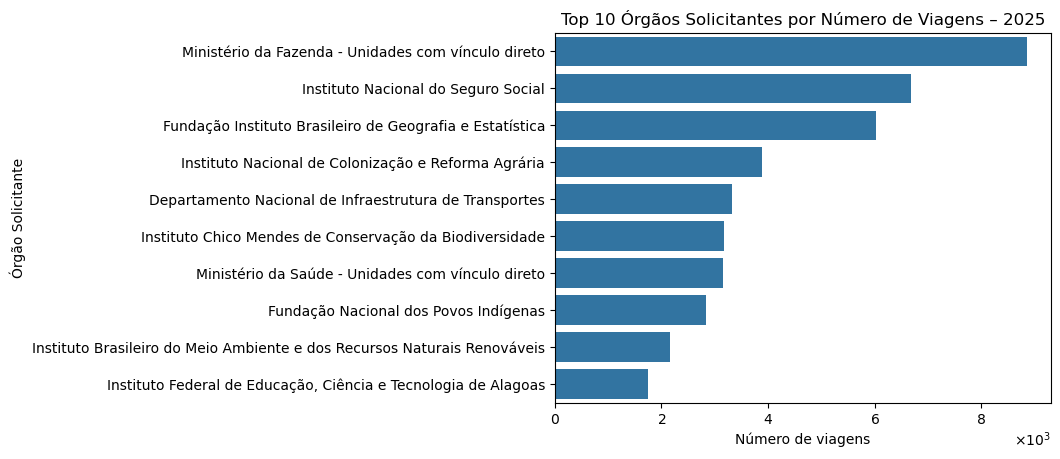

In [168]:
viagens_por_orgao_sol = (
    df['Nome órgão solicitante']
    .value_counts()
    .reset_index()
)

viagens_por_orgao_sol.columns = ['Órgão Solicitante', 'Número de Viagens']

top_10 = viagens_por_orgao_sol.head(10)

ax = sns.barplot(
    data=top_10,
    y='Órgão Solicitante',
    x='Número de Viagens'
)

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
ax.xaxis.set_major_formatter(formatter)

plt.title('Top 10 Órgãos Solicitantes por Número de Viagens – 2025')
plt.xlabel('Número de viagens')
plt.ylabel('Órgão Solicitante')
plt.show()

In [169]:
df.to_csv(
    "Viagens_2025_LIMPAS.csv",
    index=False,
    encoding="utf-8"
)

In [170]:
mapa_colunas = {
    'Identificador do processo de viagem': 'identificador_processo_viagem',
    'Número da Proposta (PCDP)': 'numero_proposta_pcdp',
    'Situação': 'situacao',
    'Viagem Urgente': 'viagem_urgente',
    'Justificativa Urgência Viagem': 'justificativa_urgencia_viagem',
    'Código do órgão superior': 'codigo_orgao_superior',
    'Nome do órgão superior': 'nome_orgao_superior',
    'Código órgão solicitante': 'codigo_orgao_solicitante',
    'Nome órgão solicitante': 'nome_orgao_solicitante',
    'CPF viajante': 'cpf_viajante',
    'Nome': 'nome',
    'Cargo': 'cargo',
    'Descrição Função': 'funcao',
    'Período - Data de início': 'data_inicio',
    'Período - Data de fim': 'data_fim',
    'Destinos': 'destinos',
    'Motivo': 'motivo',
    'Valor diárias': 'valor_diarias',
    'Valor passagens': 'valor_passagens',
    'Valor devolução': 'valor_devolucao',
    'Valor outros gastos': 'valor_outros_gastos',
    'Total gasto': 'total_gasto',
    'Mês - Volta': 'mes_volta',
    'Mês - Volta': 'mes_nome',
}


In [171]:
df = df.rename(columns=mapa_colunas)